In [1]:
"""
    Plots the loss components all models w.r.t. to hyperparameters with epochs on the x axis.
    Note that there must be a loss.csv file in the model folder which contains loss info.
    Use sample_period to downsample the epochs.
"""

main_dir = r'/home/janik.fechtelpeter/Documents/bptt/results/Reallabor1.0BestDaysNoInputs3'
hyperparameters = ['participant']
losses=['epoch_loss']
pairwise_hypers = True
exclude_outliers = False

/tmp/ipykernel_3536658/3764932129.py:51: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  results_average = results.groupby(hp).mean().unstack(list(range(1, l)))
/tmp/ipykernel_3536658/3764932129.py:52: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sem is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  results_sem = results.groupby(hp).sem().unstack(list(range(1, l)))


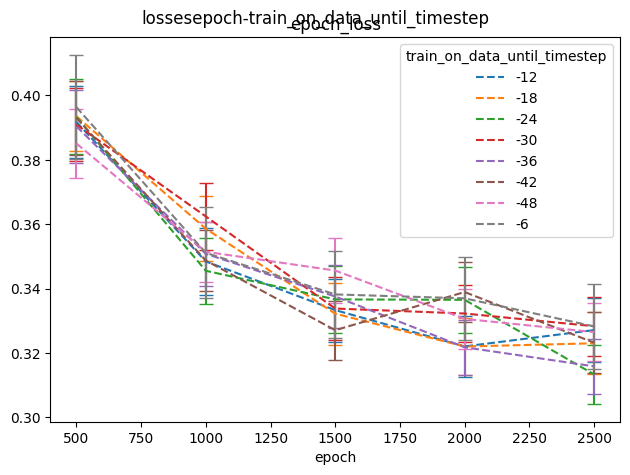

In [2]:
import sys
sys.path.append('..')

import os
import pandas as pd
import numpy as np
import itertools as it
import matplotlib.pyplot as plt
import eval_reallabor_utils
import utils
    
to_concat = []
folders = eval_reallabor_utils.get_model_folders(main_dir)
for f in folders:
    model_id = os.path.split(os.path.split(f)[0])[1]
    try:
        loss_df = pd.read_csv(os.path.join(f, 'loss.csv'), index_col=0)
    except:
        print(f'No loss data found for model {model_id}')
        continue
    loss_df = loss_df[losses]
    loss_df['epoch'] = loss_df.index
    args = utils.load_args(f)
    try:
        args['participant']
    except:
        args['participant'] = model_id.split('_')[-1][:5]
    for h in hyperparameters:
        if isinstance(args[h], list):
            loss_df[h] = args[h][0]
        else:
            loss_df[h] = args[h]
    loss_df['model_id'] = model_id
    to_concat.append(loss_df)
results = pd.concat(to_concat, ignore_index=True)
if exclude_outliers:
    for l in losses:
        threshold = results[l].quantile(0.95)
        results.loc[results[l] > threshold, l] = np.nan

if pairwise_hypers:
    hyperset = it.chain.from_iterable(it.combinations(
        hyperparameters, r) for r in range(1, len(hyperparameters)+1))
else:
    hyperset = [hyperparameters]
for hp in hyperset:
    hp = ['epoch'] + list(hp)
    fig, axes_list = plt.subplots(
        nrows=len(losses), ncols=1, squeeze=False)
    l = len(hp)
    results_average = results.groupby(hp).mean().unstack(list(range(1, l)))
    results_sem = results.groupby(hp).sem().unstack(list(range(1, l)))

    for loss_name, axes in zip(losses, axes_list):
        to_plot = results_average[loss_name]
        to_plot_sem = results_sem[loss_name]

        plot = to_plot.plot(linestyle='--', marker='',
                            yerr=to_plot_sem, ax=axes[0],
                            markersize=1, capsize=5,
                            title=loss_name, zorder=0)

        if 'feat_name' in hp:
            plt.setp(axes[0].get_xticklabels(), rotation=45,
                        horizontalalignment='right')

    suptitle = 'losses' + '-'.join(hp)

    fig.tight_layout()
    plt.suptitle(suptitle)